In [17]:
import matplotlib.pyplot as plt, numpy as np 
import json

lang_prefix = ["eng", "ddo", "lez", "git", "ntu"]
prefix_dict = {"eng":"English", "ddo":"Tsez", "lez": "Lezgi","git": "Gitksan", "ntu": "Natugu"}
main_evals = {}
morph_len_evals = {}
#Function to extract f_scores from output JSON files
def extract_fscores(model_type, scores_dict, output_data):
        i = 0 
        for item in output_data:
            if model_type in item["model"]:
                parts = item["model"].split("_")
                for part in parts:
                    if part.isdigit():
                        i = int(part) 
                        scores_dict[i] = float(item["f_measure"])

#Function to plot vocab_size vs. f_score plots for BPE and ULM
def spm_plot(fscores_bpe=None, fscores_ulm=None, title_fill="", combined=False):
    if fscores_bpe is not None:
        x1 = list(fscores_bpe.keys())
        y1 = list(fscores_bpe.values())
    if fscores_ulm is not None:
        x2 = list(fscores_ulm.keys())
        y2 = list(fscores_ulm.values())
    fig, ax = plt.subplots()
    ax.set_xlabel('vocab_size', fontsize=16)
    ax.set_ylabel('f_measure', fontsize=16)
    if fscores_bpe is not None and fscores_ulm is not None:
        ax.set_title(f'{title_fill}')
        ax.plot(x1, y1, label='BPE')
        ax.plot(x2, y2, label='ULM')
        ax.legend(fontsize=16)
    elif fscores_bpe is not None:
        ax.set_title(f'{title_fill}')
        ax.plot(x1, y1, label='BPE')
    elif fscores_ulm is not None:
        ax.set_title(f'{title_fill}')
        ax.plot(x2, y2, label='BPE')


#Function to plot --morph-length vs f_score plots or --num-morph-types vs. f_score plots for Morfessor
def morfessor_plot(fscores_morfessor, title_fill, type):
    a = list(fscores_morfessor.keys())
    b = list(fscores_morfessor.values())
    if type == "morph_length":
         xlabel = "Morph Length"
         title = f"{title_fill}"
    elif type == "num_morph_types":
         xlabel = "Number of morpheme types"
         title = f"{title_fill}"
    fig, ax = plt.subplots()
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel('f_measure', fontsize=16)
    ax.set_title(title)
    if type == "morph_length":
        ax.bar(a,b)
    elif type == "num_morph_types":
        ax.scatter(a, b)

## Hyperparameter plots for all languages and models

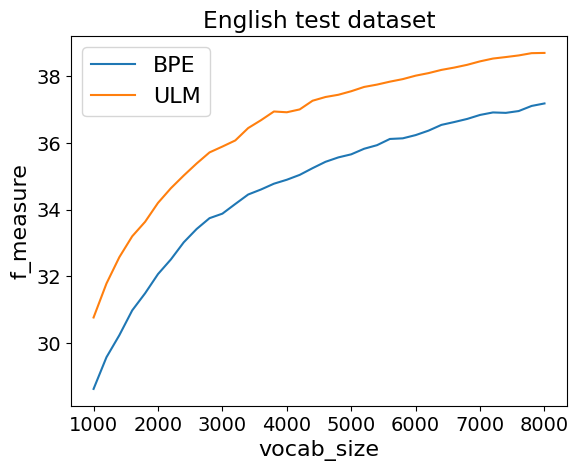

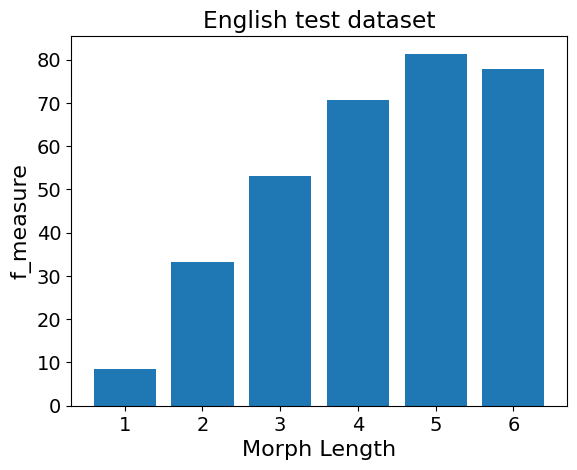

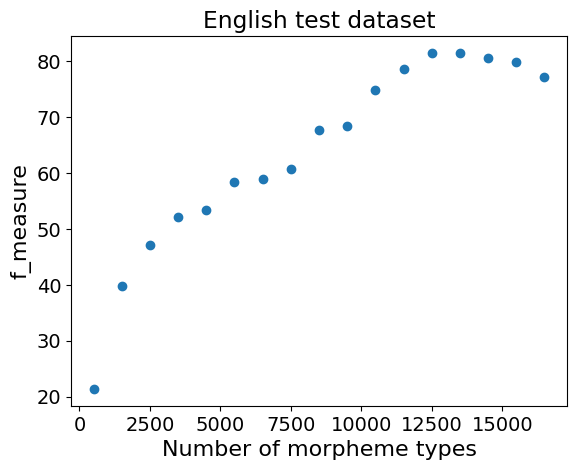

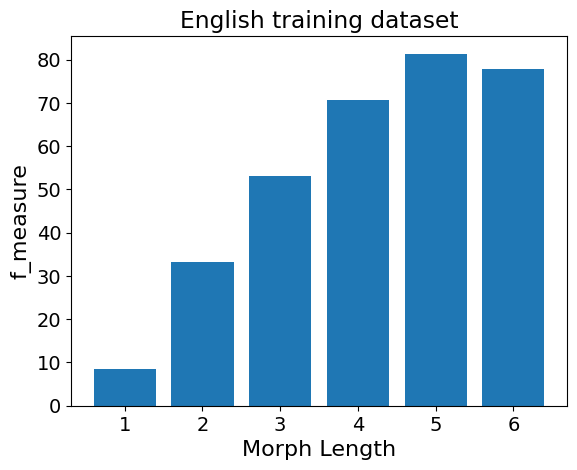

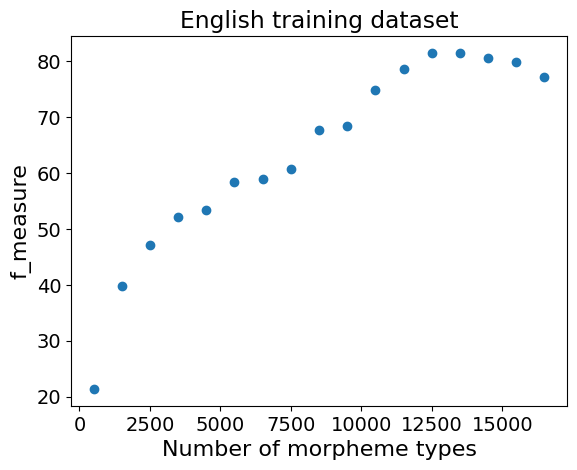

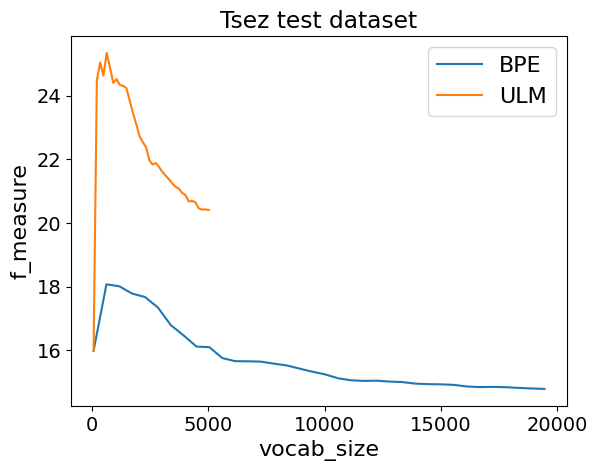

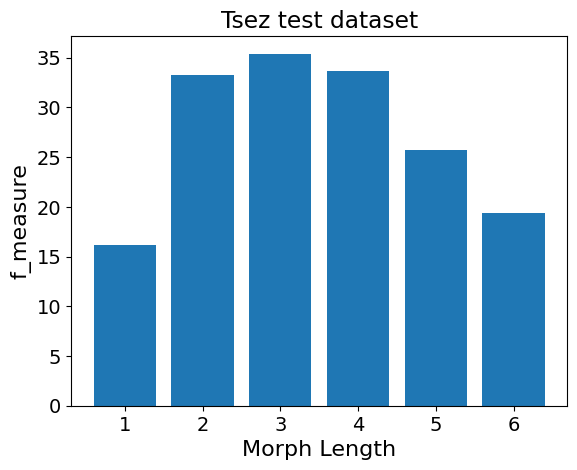

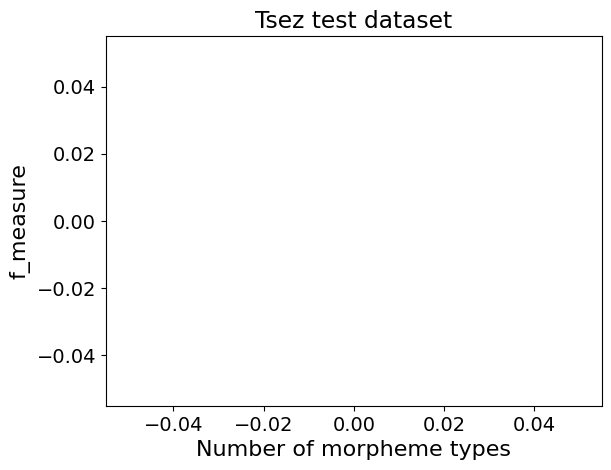

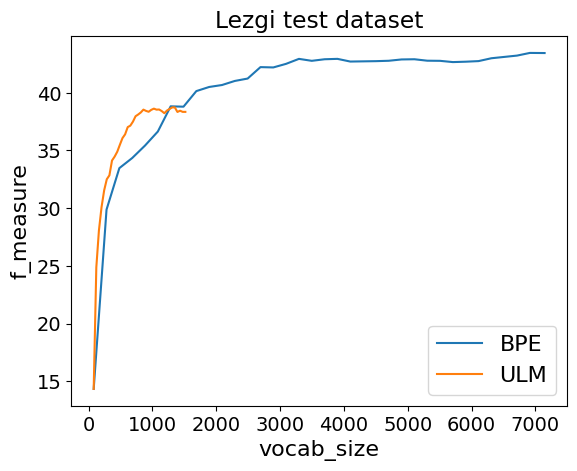

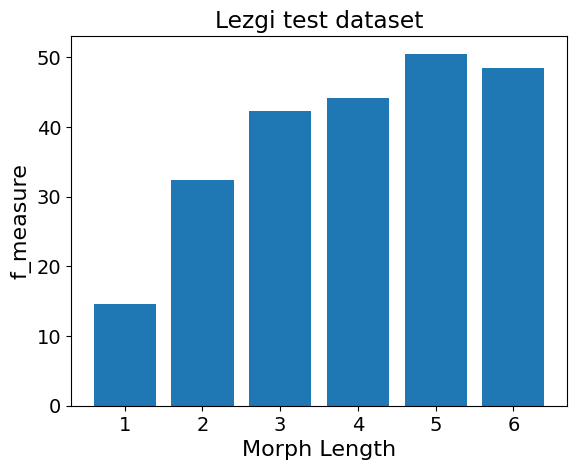

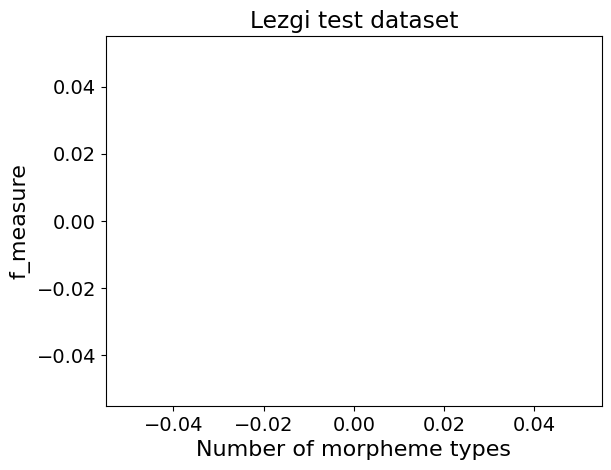

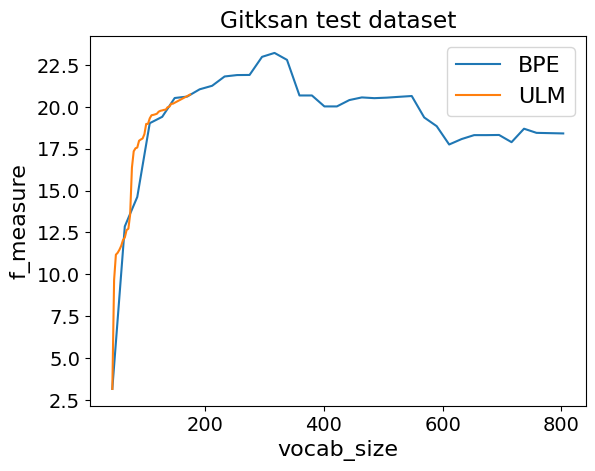

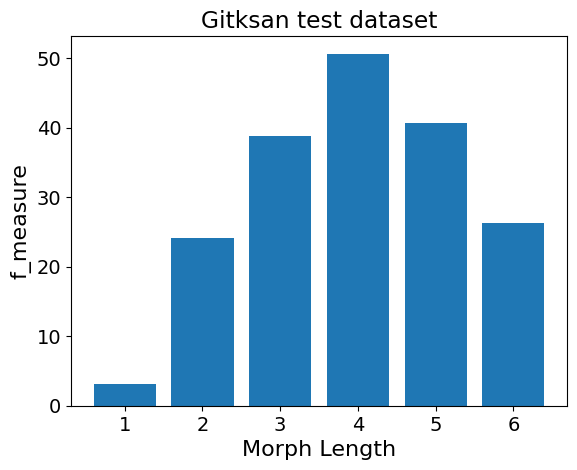

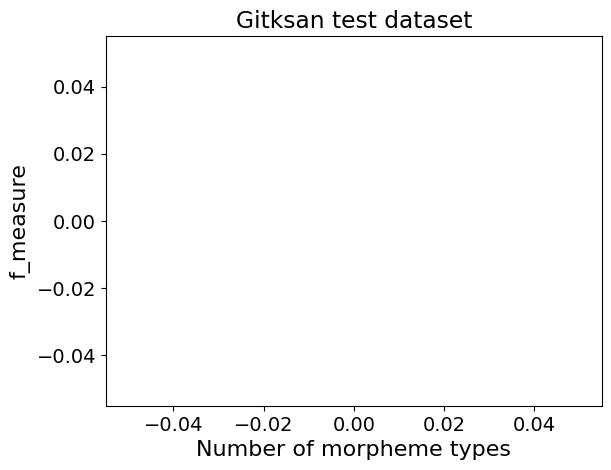

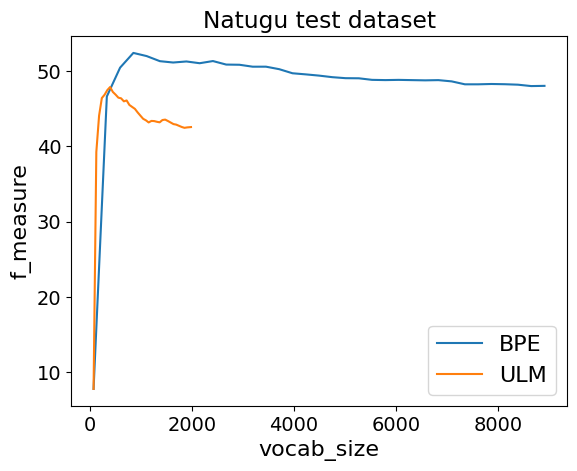

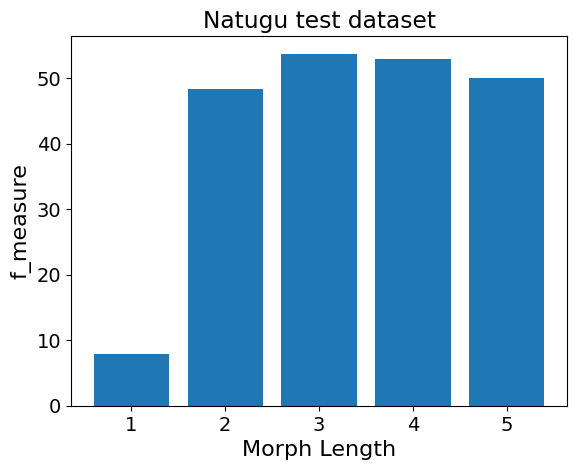

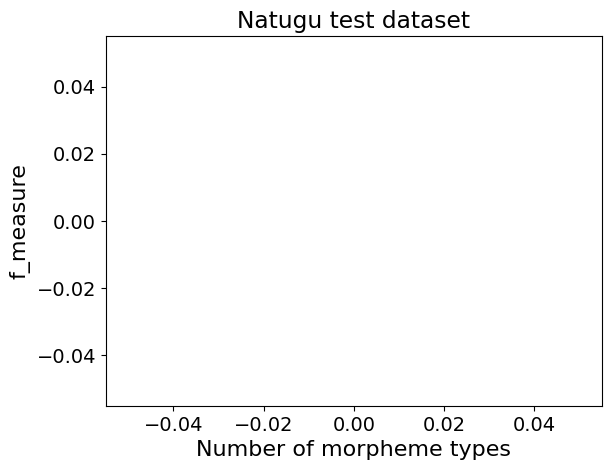

In [18]:

for lang in lang_prefix: 
    output_file = f"outputs\\{lang}.output.json"
    with open(output_file, 'r') as f:
        output_dict = json.load(f)

    output_data = output_dict["data"]
    fscores_bpe = {}
    fscores_ulm = {}
    fscores_morfessor_len = {}
    fscores_morfessor_types = {}
    fscores_morfessor_training_len = {}
    fscores_morfessor_training_types = {}
    

    extract_fscores("bpe", fscores_bpe, output_data=output_data)
    extract_fscores("ulm", fscores_ulm, output_data=output_data)
    extract_fscores("morfessor_len", fscores_morfessor_len, output_data=output_data)
    extract_fscores("morfessor_types", fscores_morfessor_types, output_data=output_data)
    
    
    avg_bpe = sum(fscores_bpe.values()) / len(fscores_bpe.values())
    avg_ulm = sum(fscores_ulm.values()) / len(fscores_ulm.values())
    # for (key, value) in fscores_bpe.items():
    #     if value == avg_bpe:
    #         main_evals[f"{lang}_bpe_{key}"] = avg_bpe
    #         break 
    # for (key, value) in fscores_ulm.items():
    #     if value == avg_ulm:
    #         main_evals[f"{lang}_ulm_{key}"] = avg_ulm
    #         break 
    for item in output_data:
            if "morfessor_standard" in item["model"]:
                main_evals[f"{lang}_morfessor_standard"] = float(item['f_measure'])
    main_evals[f"{lang}_bpe_standard"] = avg_bpe
    main_evals[f"{lang}_ulm_standard"] = avg_ulm

    for ml, f in fscores_morfessor_len.items():
         morph_len_evals[f"{lang}_morfessor_len_{ml}"] = f

    spm_plot(fscores_bpe=fscores_bpe, fscores_ulm=fscores_ulm, title_fill=f"{prefix_dict[lang]} test dataset")
    morfessor_plot(fscores_morfessor=fscores_morfessor_len, title_fill=f"{prefix_dict[lang]} test dataset", type="morph_length")
    morfessor_plot(fscores_morfessor=fscores_morfessor_types, title_fill=f"{prefix_dict[lang]} test dataset", type="num_morph_types")

    if lang == "eng":
        extract_fscores("morfessor_training_len", fscores_morfessor_training_len, output_data=output_data)
        extract_fscores("morfessor_training_types", fscores_morfessor_training_types, output_data=output_data)
        morfessor_plot(fscores_morfessor=fscores_morfessor_len, title_fill=f"{prefix_dict[lang]} training dataset", type="morph_length")
        morfessor_plot(fscores_morfessor=fscores_morfessor_types, title_fill=f"{prefix_dict[lang]} training dataset", type="num_morph_types")

## Main plot: Comparing "standard" evaluations of all the models to each other

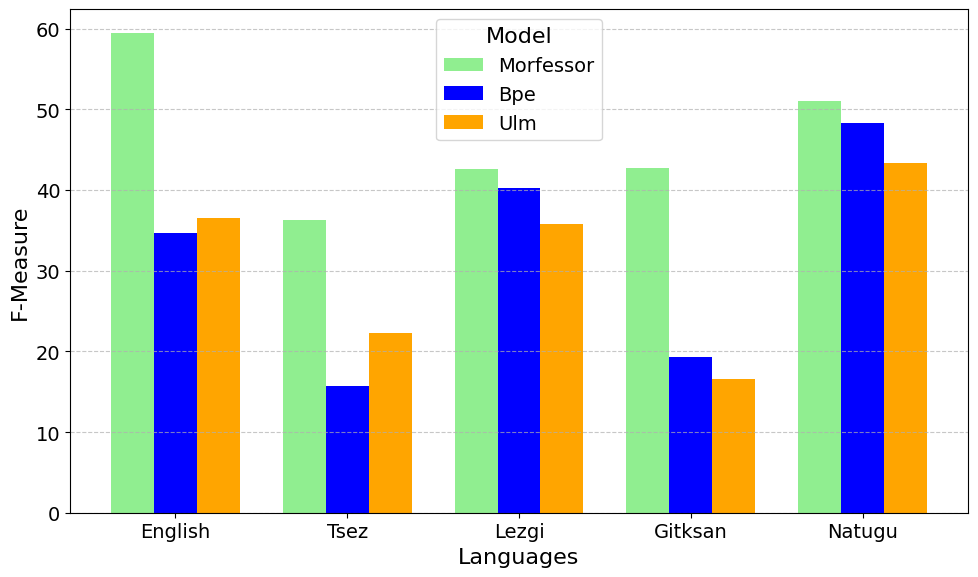

In [21]:
methods = ['morfessor', 'bpe', 'ulm']
data_values = {lang: [main_evals[f'{lang}_{method}_standard'] for method in methods] for lang in lang_prefix}
colors = {'morfessor': 'lightgreen', 'bpe': 'blue', 'ulm': 'orange'}

# Prepare data for the bar plot
x = np.arange(len(lang_prefix))  # The label locations
width = 0.25  # Width of the bars

# Increase global font size
plt.rcParams.update({'font.size': 14})

# Create sub-bars for each method
fig, ax = plt.subplots(figsize=(10, 6))
for i, method in enumerate(methods):
    method_values = [data_values[lang][i] for lang in lang_prefix]
    ax.bar(x + i * width - width, method_values, width, label=method.capitalize(), color=colors[method])

# Add labels, title, and legend with increased font sizes
ax.set_xlabel('Languages', fontsize=16)
ax.set_ylabel('F-Measure', fontsize=16)
# ax.set_title('F-Measure by Language and Model', fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(prefix_dict.values(), fontsize=14)
ax.legend(title='Model', fontsize=14, title_fontsize=16)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Increase tick label font size
ax.tick_params(axis='both', labelsize=14)

# Display the plot
plt.tight_layout()
plt.show()

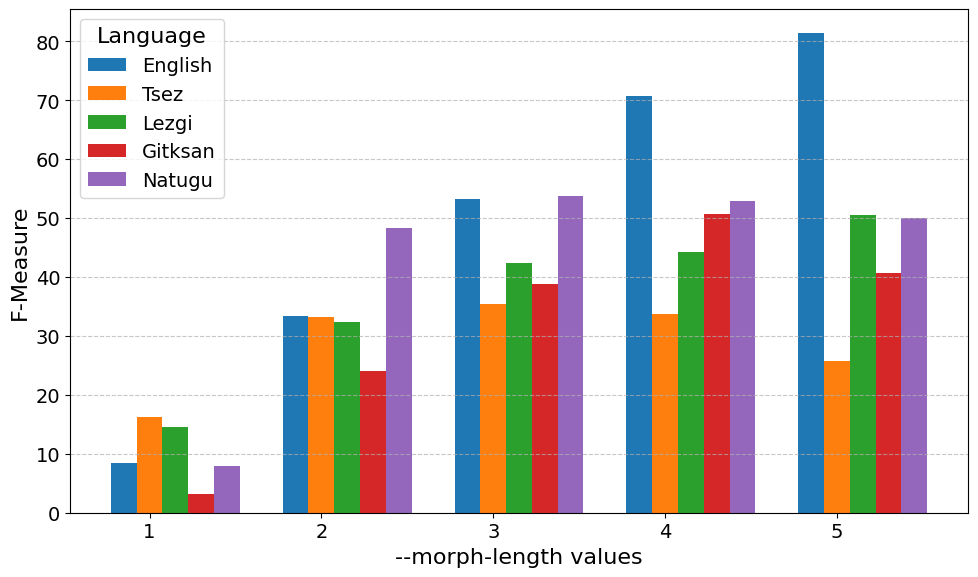

In [22]:
morph_lengths = [1,2,3,4,5]
from collections import defaultdict
length_dict = defaultdict(list)
for lang in lang_prefix:
    for label, score in morph_len_evals.items():
        if lang in label:
            length_dict[lang].append(score)
# Prepare data for the bar plot
x = np.arange(len(morph_lengths))  # The label locations
width = 0.15  # Width of the bars

# Increase global font size
plt.rcParams.update({'font.size': 14})

# Create sub-bars for each method
fig, ax = plt.subplots(figsize=(10, 6))
length_values = []
for i, l in enumerate(lang_prefix):
    length_values = [length_dict[l][morph_length - 1] for morph_length in morph_lengths]
    ax.bar(x + i * width - width, length_values, width, label=prefix_dict[l])

# Add labels, title, and legend with increased font sizes
ax.set_xlabel('--morph-length values', fontsize=16)
ax.set_ylabel('F-Measure', fontsize=16)
# ax.set_title('F-Measure by Morph-Length', fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(morph_lengths, fontsize=14)
ax.legend(title='Language', fontsize=14, title_fontsize=16)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Increase tick label font size
ax.tick_params(axis='both', labelsize=14)

# Display the plot
plt.tight_layout()
plt.show()